# Fine-tune BERT & RoBERTa for Aspect Category Detection in PyTorch Using Hugging Face 

#### The code was adopted and modified for this task from the work of [George Mihaila](https://github.com/gmihaila).
#### Source code: https://gmihaila.medium.com/fine-tune-transformers-in-pytorch-using-transformers-57b40450635


## Info

This notebook is designed to use a pretrained BERT or RoBERTa model and fine-tune it on an Aspect Category Detection task. All the instructions on the setups used can be found on "*Chapter 4: Classification Method* " of the thesis report.

This notebook is using the [AutoClasses](https://huggingface.co/transformers/model_doc/auto.html) from 
[transformer](https://github.com/huggingface/transformers) by [Hugging Face](https://huggingface.co/)  functionality. 
This functionality can guess a model's configuration, tokenizer and architecture just by passing in the model's name. This allows us to reuse the code on a large number of transformers models.



## How to use this notebook? 

This notebook was built with reusability in mind. The way I load the dataset into the PyTorch class is pretty standard and can be easily reused for any other dataset.

The only modifications needed to use your own dataset will be in reading in the dataset inside the PyTorch **Dataset** class under **Dataset and DataLoader** tab. The **DataLoader** will return a dictionary of batch inputs format so that it can be fed straight to the model using the statement: `outputs = model(**batch)`. *As long as this statement holds, the rest of the code will work.*

Basic parameters are defined under the **Imports** tab:
* `epochs` - will be used as the number of epochs to train the model. 
* `batch_size` - will be used as the batch size during training. The larger the batch the more RAM / GPU memory it will take. 
* `max_length` - I use this variable if I want to truncate text inputs to a shorter length than the maximum allowed word piece tokens sequence length. The shorter the sequence the faster it will train.
* `model_name_or_path` - This is where I put the transformer model I want to train. In this work, I used `bert-base-uncased` and `roberta-base`.
* `labels_ids` - It is mostly the case that labels have a name / meaning. We need to associate each name / meaning with a number / id. I use this variable to create a dictionary that maps labels names to ids. This will be used later inside the PyTorch Dataset class.



## Dataset

This notebook will cover the fine-tuning of BERT & RoBERTa for Aspect Based Sentiment Analysis. The Dataset used for this finetuning step is the in-house annotated airline customer feedbacks set. For this notebook, only the Aspect Category will be considered. 



# Imports

Import all needed libraries for this notebook.


In [1]:
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from utils import plot_dict, plot_confusion_matrix          
from sklearn.metrics import classification_report, accuracy_score
from transformers import (AutoConfig, 
                          AutoModelForSequenceClassification, 
                          AutoTokenizer, AdamW, 
                          get_linear_schedule_with_warmup,
                          set_seed,
                          )
import pandas as pd
from datetime import datetime

Declare parameters used for this notebook:

In [2]:

# Set seed for reproducibility,
set_seed(123)

# Number of training epochs
epochs = 4

# Number of batch_size - depending on the max sequence length and GPU memory.
batch_size = 64  #32  (using 64 returns 32 batch size)

# Padd or truncate text sequences to a specific length
# if `None` it will use maximum sequence allowed by model.
max_length = 124

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'roberta-base'     # For this work I used 'roberta-base'  and  'bert-base-uncased' 

# Dicitonary of labels and their id - this will be used to convert.
# String labels to number.
labels_ids = { 'Service' : 0, 'Company' : 1, 'Staff' : 2, 'Price' : 3, 'Travel' : 4, 
          'Aircraft equipment' : 5, 'Food' : 6, 'Safety' : 7, 'Boarding' : 8, 
          'Luggage' : 9,'Information' : 10, 'Others' : 11, 'Multiple' : 12, 'NA' : 13
                }                                                     

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)

# Helper Functions

All Classes and functions that will be used in this notebook are kept under this section to help maintain a clean look of the notebook:

* AirlineFeedbackDataset
* train
* validation

In [3]:
class AirlineFeedbackDataset(Dataset):
    r"""PyTorch Dataset class for loading data.

    This is where the data parsing happens and where the text gets encoded using
    loaded tokenizer.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

    Arguments:

    path (:obj:`str`):
        Path to the data partition.

    use_tokenizer (:obj:`transformers.tokenization_?`):
        Transformer type tokenizer used to process raw text into numbers.

    labels_ids (:obj:`dict`):
        Dictionary to encode any labels names into numbers. Keys map to 
        labels names and Values map to number associated to those labels.

    max_sequence_len (:obj:`int`, `optional`)
        Value to indicate the maximum desired sequence to truncate or pad text
        sequences. If no value is passed it will used maximum sequence size
        supported by the tokenizer and model.

    """

    def __init__(self, path, use_tokenizer, labels_ids, max_sequence_len=None):
        # Read in the data
        df_train = pd.read_csv(path, delimiter=';', header= 0, dtype= str, keep_default_na=False, encoding= 'utf-8')
        df_train = df_train.dropna()
        # Check max sequence length.
        max_sequence_len = 64
        # use_tokenizer.max_len if max_sequence_len is None else max_sequence_len
        texts = []
        labels = []
        print('Reading partitions...')
        # Since the labels are defined by folders with data we loop 
        # through each label.
        [labels.append(labels_ids[label]) for label in df_train['Aspect_Category'].astype(str)] 
        [texts.append(sentence) for sentence in df_train['Sentence'].astype(str)]   

        # Number of exmaples.
        self.n_examples = len(labels)
        # Use tokenizer on texts. This can take a while.
        print('Using tokenizer on all texts. This can take a while...')
        self.inputs = use_tokenizer(texts, add_special_tokens=True, truncation=True, padding=True, return_tensors='pt',  max_length=max_sequence_len)
        # Get maximum sequence length.
        self.sequence_len = self.inputs['input_ids'].shape[-1]
        print('Texts padded or truncated to %d length!' % self.sequence_len)
        # Add labels.
        self.inputs.update({'labels':torch.tensor(labels)})
        print('Finished!\n')

        return

    def __len__(self):
        r"""When used `len` return the number of examples.

        """

        return self.n_examples

    def __getitem__(self, item):
        r"""Given an index return an example from the position.

        Arguments:

          item (:obj:`int`):
              Index position to pick an example to return.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holddes the statement `model(**Returned Dictionary)`.

        """

        return {key: self.inputs[key][item] for key in self.inputs.keys()}



def train(dataloader, optimizer_, scheduler_, device_):
    r"""
    Train pytorch model on a single pass through the data loader.

    It will use the global variable `model` which is the transformer model 
    loaded on `_device` that we want to train on.

    This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

    Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

    Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
    """

    # Use global variable for model.
    global model

    # Tracking variables.
    predictions_labels = []
    true_labels = []
    # Total loss for this epoch.
    total_loss = 0

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    for batch in tqdm(dataloader, total=len(dataloader)):

        # Add original labels - use later for evaluation.
        true_labels += batch['labels'].numpy().flatten().tolist()

        # move batch to device
        batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this a bert model function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple along with the logits. We will use logits
        # later to calculate training accuracy.
        loss, logits = outputs[:2]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Convert these logits to list of predicted labels values.
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()

    # Calculate the average loss over the training data.
    avg_epoch_loss = total_loss / len(dataloader)
  
    # Return all true labels and prediction for future evaluations.
    return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
    r"""Validation function to evaluate model performance on a 
    separate set of data.

    This function will return the true and predicted labels so we can use later
    to evaluate the model's performance.

    This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

    Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

    Returns:

    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
    """

    # Use global variable for model.
    global model

    # Tracking variables
    predictions_labels = []
    true_labels = []
    #total loss for this epoch.
    total_loss = 0

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Evaluate data for one epoch
    for batch in tqdm(dataloader, total=len(dataloader)):

        # add original labels
        true_labels += batch['labels'].numpy().flatten().tolist()

        # move batch to device
        batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(**batch)

            # The call to `model` always returns a tuple, so we need to pull the 
            # loss value out of the tuple along with the logits. We will use logits
            # later to to calculate training accuracy.
            loss, logits = outputs[:2]

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_loss += loss.item()

            # get predicitons to list
            predict_content = logits.argmax(axis=-1).flatten().tolist()

            # update list
            predictions_labels += predict_content

    # Calculate the average loss over the training data.
    avg_epoch_loss = total_loss / len(dataloader)

    # Return all true labels and prediciton for future evaluations.
    return true_labels, predictions_labels, avg_epoch_loss

# Load Model and Tokenizer

Loding the three esential parts of pretrained transformers: configuration, tokenizer and model. We also need to load model to the device we're planning to use (GPU / CPU).

In [4]:
# Get model configuration.
print('Loading configuration...')
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name_or_path, 
                                          num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)

# Get the actual model.
print('Loading model...')
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, 
                                                           config=model_config)

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuration...
Loading tokenizer...
Loading model...
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base an

# Dataset and DataLoader

Create the PyTorch Dataset and DataLoader objects that will be used to feed data into our model.

In [5]:
print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = AirlineFeedbackDataset(path="path/to/train.csv", 
                               use_tokenizer=tokenizer, 
                               labels_ids=labels_ids,
                               max_sequence_len=max_length)

print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with ...')
# Create pytorch dataset.
valid_dataset =  AirlineFeedbackDataset(path="path/to/valid.csv", 
                               use_tokenizer=tokenizer, 
                               labels_ids=labels_ids,
                               max_sequence_len=max_length)

print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with Train...
Reading partitions...
Using tokenizer on all texts. This can take a while...
Texts padded or truncated to 64 length!
Finished!

Created `train_dataset` with 1996 examples!
Created `train_dataloader` with 32 batches!

Dealing with ...
Reading partitions...
Using tokenizer on all texts. This can take a while...
Texts padded or truncated to 64 length!
Finished!

Created `valid_dataset` with 250 examples!
Created `eval_dataloader` with 4 batches!


# Train

Create optimizer and scheduler use by PyTorch in training.

Loop through the number of defined epochs and call the **train** and **validation** functions.

Outputs similar info after each epoch as in Keras: *train_loss:  - val_loss:  - train_acc: - valid_acc*.

After training, plot train and validation loss and accuracy curves to check how the training went.

Epoch



Training on batches...



Validation on batches...



  train_loss: 2.29294 - val_loss: 2.07085 - train_acc: 0.32715 - valid_acc: 0.33600


Training on batches...



Validation on batches...



  train_loss: 1.82985 - val_loss: 1.52297 - train_acc: 0.46192 - valid_acc: 0.55600


Training on batches...



Validation on batches...



  train_loss: 1.43326 - val_loss: 1.24528 - train_acc: 0.58267 - valid_acc: 0.64400


Training on batches...



Validation on batches...



  train_loss: 1.23044 - val_loss: 1.15770 - train_acc: 0.64078 - valid_acc: 0.68800


Duration: 0:52:55.917090


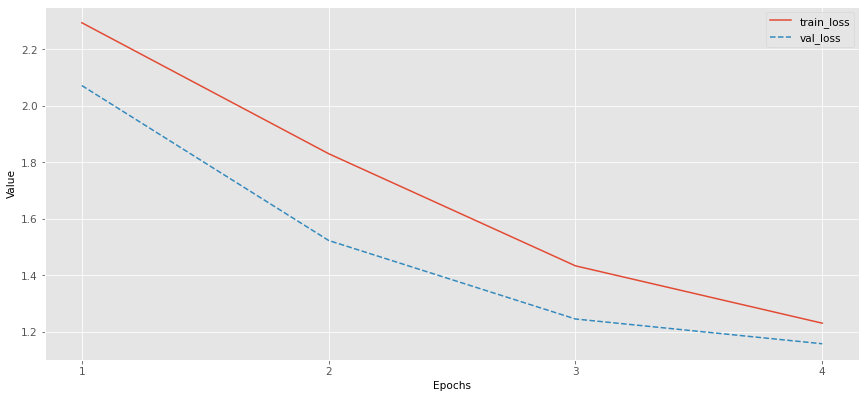

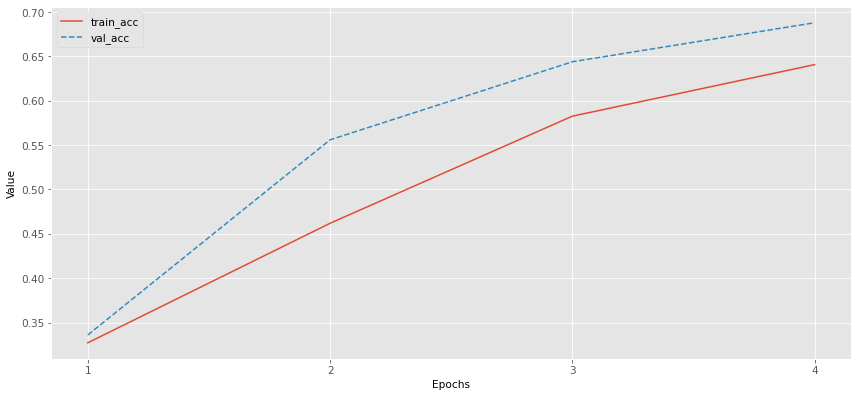

In [6]:
start_time = datetime.now()

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = 3e-5, # args.learning_rate 
                  eps = 1e-8 # args.adam_epsilon 
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
    print()
    print('Training on batches...')
    # Perform one full pass over the training set.
    train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
    train_acc = accuracy_score(train_labels, train_predict)

    # Get prediction form model on validation data. 
    print('Validation on batches...')
    valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
    val_acc = accuracy_score(valid_labels, valid_predict)

    # Print loss and accuracy values to see how training evolves.
    print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
    print()

    # Store the loss value for plotting the learning curve.
    all_loss['train_loss'].append(train_loss)
    all_loss['val_loss'].append(val_loss)
    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))



# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Evaluate

When dealing with classification is useful to look at precision recall and F1 score.

A good gauge to have when evaluating a model is the confusion matrix.

In [7]:
# SAVE MODELS TO THE MODELS FOLDER WITH TORCH
torch.save(tokenizer, "models/r_aspect_tokenizer_3e")
torch.save(model, "models/r_aspect_model_3e")
torch.save(device, "models/r_aspect_device_3e")
 
# # some time later...
 
# # load the model from disk
# tokenizer = torch.load("models/r_aspect_tokenizer_3e")
# model = torch.load("models/r_aspect_model_3e")
# device = torch.load("models/r_aspect_device_3e")

In [8]:
# Evaluation on test data.
# Create pytorch dataset.
test_dataset =  AirlineFeedbackDataset(path="path/to/test.csv", 
                               use_tokenizer=tokenizer, 
                               labels_ids=labels_ids,
                               max_sequence_len=max_length)

print('Created `test_dataset` with %d examples!'%len(test_dataset))

# Move pytorch dataset into dataloader.
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print('Created `test_dataloader` with %d batches!'%len(test_dataloader))

true_labels, predictions_labels, avg_epoch_loss = validation(test_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)


Reading partitions...
Using tokenizer on all texts. This can take a while...
Texts padded or truncated to 64 length!
Finished!

Created `test_dataset` with 249 examples!
Created `test_dataloader` with 4 batches!



                    precision    recall  f1-score   support

           Service       0.50      0.47      0.49        19
           Company       0.74      0.78      0.76        18
             Staff       0.85      0.94      0.89        31
             Price       0.00      0.00      0.00         5
            Travel       0.55      0.30      0.39        20
Aircraft equipment       0.79      0.88      0.84        26
              Food       0.82      0.90      0.86        10
            Safety       0.00      0.00      0.00         3
          Boarding       0.67      0.22      0.33         9
           Luggage       0.88      0.58      0.70        12
       Information       0.00      0.00      0.00         8
            Others       0.00      0.00      0.00         1
          Multiple       0.00      0.00      0.00        11
                NA       0.61      0.93      0.74        76

          accuracy                           0.68       249
         macro avg       0.46      0.

Confusion matrix


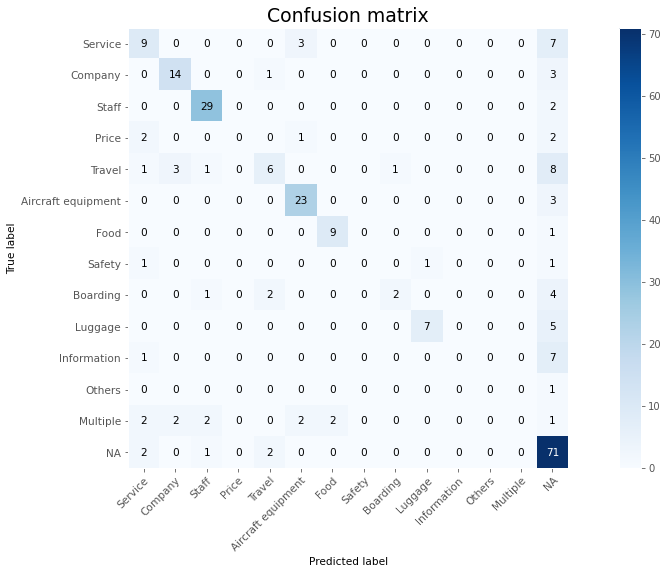

In [9]:
# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=list(labels_ids.keys()), normalize=False, width= 2, height= 2,
                      magnify=3,
                      );

In [ ]:
# Check examples of classification comparing gold label and prediction
# the output is hidden because it shows private data

test_df = pd.read_csv("path/to/test.csv", delimiter=';', header= 0, dtype= str, keep_default_na=False, encoding= 'utf-8')
sentences = test_df['Sentence']

def get_key(val):
    """"
    function to return the key 
    for any value in a dictionary
    """"
    for key, value in labels_ids.items():
         if val == value:
            return key
 
    return "key doesn't exist"

i = 1
for s, gold, pred in zip(sentences, true_labels, predictions_labels):
    print('SENTENCE', i, ':  ', s)
    print('GOLD : ', get_key(gold), '       PREDICTION -->', get_key(pred))
    i += 1
    print()
    print()

Example output: 

SENTENCE 1 :   Way above excellent service and we will remember that for all our future trips even when the kids are not going with us!\
GOLD :  Service    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; PREDICTION --> Service

## End of the notebook